In [3]:
import pandas as pd
import numpy as np
import tsfresh
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

import os

import matplotlib.pyplot as plt

# keras goodies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, BatchNormalization, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import metrics as kmetrics
import tensorflow.keras.backend as K

from scipy import signal


In [11]:
#Load Clean Respeck Recording to base_df
clean_data_folder = "../pdiot-data/2021/Respeck_recordings_clean.csv"
base_df = pd.read_csv(clean_data_folder)

/afs/inf.ed.ac.uk/user/s18/s1870697/miniconda3/envs/pdiot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
columns_of_interest_initial = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z','subject_id','activity_code', 'activity_type','recording_id']
columns_of_interest_training = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [7]:
all_subject_ids = base_df.subject_id.unique()

In [12]:
base_df = base_df.dropna(subset=columns_of_interest_initial).reset_index(drop=True)
base_df

,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,sensor_type,activity_type,activity_code,subject_id,notes,recording_id
0,1.633516e+12,0.261475,-1.116516,-0.502991,-0.812500,12.312500,19.500000,Respeck,Climbing stairs,12.0,s1870467,rob,Respeck_s1870467_Climbing stairs_06-10-2021_11...
1,1.633516e+12,-0.177734,-0.636292,-0.477600,-5.265625,2.953125,-9.281250,Respeck,Climbing stairs,12.0,s1870467,rob,Respeck_s1870467_Climbing stairs_06-10-2021_11...
2,1.633516e+12,0.351562,-0.879456,-0.335754,5.671875,24.656250,-10.562500,Respeck,Climbing stairs,12.0,s1870467,rob,Respeck_s1870467_Climbing stairs_06-10-2021_11...
3,1.633516e+12,0.298584,-1.253479,-0.299622,-3.609375,2.687500,5.890625,Respeck,Climbing stairs,12.0,s1870467,rob,Respeck_s1870467_Climbing stairs_06-10-2021_11...
4,1.633516e+12,0.056152,-0.777405,-0.210754,-14.328125,5.421875,8.140625,Respeck,Climbing stairs,12.0,s1870467,rob,Respeck_s1870467_Climbing stairs_06-10-2021_11...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
492670,1.632930e+12,-0.376465,-0.746399,0.693543,-0.171875,-0.953125,1.281250,Respeck,Sitting bent backward,5.0,s2211228,NaN,Respeck_s2211228_Sitting bent backward_29-09-2...
492671,1.632930e+12,-0.345703,-0.749329,0.677429,-0.671875,-0.187500,-1.015625,Respeck,Sitting bent backward,5.0,s2211228,NaN,Respeck_s2211228_Sitting bent backward_29-09-2...
492672,1.632930e+12,-0.368408,-0.745422,0.690857,-0.218750,-0.640625,0.375000,Respeck,Sitting bent backward,5.0,s2211228,NaN,Respeck_s2211228_Sitting bent backward_29-09-2...
492673,1.632930e+12,-0.363281,-0.747375,0.689148,0.078125,0.796875,-0.046875,Respeck,Sitting bent backward,5.0,s2211228,NaN,Respeck_s2211228_Sitting bent backward_29-09-2...


In [7]:
s1541031_df = base_df[base_df['subject_id'] == 's1541031']


In [9]:

activities = base_df['activity_type'].unique()
print(activities)

['Climbing stairs' 'Standing' 'Movement' 'Lying down on stomach'
 'Sitting bent backward' 'Lying down left' 'Lying down on back'
 'Descending stairs' 'Sitting bent forward' 'Walking at normal speed'
 'Running' 'Lying down right' 'Desk work' 'Sitting' 'Falling on knees'
 'Falling on the back' 'Falling on the right' 'Falling on the left']


In [41]:
#Preprocessing outliers, meh. So far no improvements
#Update: works decent with normalising all columns. No improvement, but better to keep it for stability of data.
from sklearn.preprocessing import RobustScaler


scaler = RobustScaler()
scaler = scaler.fit(base_df[columns_of_interest_training].values)
base_df.loc[:,columns_of_interest_training] = scaler.transform(base_df[columns_of_interest_training].to_numpy())


In [49]:
base_df[columns_of_interest_training]=(base_df[columns_of_interest_training]-base_df[columns_of_interest_training].mean())/base_df[columns_of_interest_training].std()


In [31]:
def filter(dataframe, cutoff=0.1):
    b, a = signal.butter(1, cutoff, btype='lowpass') #low pass filter

    x_low = signal.filtfilt(b, a, dataframe.accel_x)
    y_low = signal.filtfilt(b, a, dataframe.accel_y)
    z_low = signal.filtfilt(b, a, dataframe.accel_z)

    dataframe.loc[:, 'accel_x'] = x_low
    dataframe.loc[:, 'accel_y'] = y_low
    dataframe.loc[:, 'accel_z'] = z_low
    return dataframe

# def filter(dataframe):
#     n = 15  # the larger n is, the smoother curve will be
#     b = [1.0 / n] * n
#     a = 1

#     x_low = signal.lfilter(b, a, dataframe.accel_x)
#     y_low = signal.lfilter(b, a, dataframe.accel_y)
#     z_low = signal.lfilter(b, a, dataframe.accel_z)

#     dataframe.loc[:, 'accel_x'] = x_low
#     dataframe.loc[:, 'accel_y'] = y_low
#     dataframe.loc[:, 'accel_z'] = z_low
    
#     return dataframe

from scipy import signal
def smooth_signal(df,window_size=9,order=3):
    new_df = pd.DataFrame()
    for rid, group in df.groupby("recording_id"):
        group[columns_of_interest_training] = group[columns_of_interest_training].apply(lambda x: signal.savgol_filter(x,window_size,3))
        new_df = pd.concat([new_df,group])
    return new_df
    



In [61]:
base_df[bas.hist(column='gyro_z')

SyntaxError: EOL while scanning string literal (2407709857.py, line 1)

In [13]:
grouped_falling_label = 'Falling (Grouped)'
grouped_lying_label = 'Lying (Grouped)'
grouped_sitting_or_standing_label = 'Sitting/Standing'


def grouping_activities_together(base_df, individual_activities_to_group, new_label):
    grouped_dataframes = []
    for act, group in base_df.groupby("activity_type"):
        if act in individual_activities_to_group:
            group['activity_type'] = new_label

        grouped_dataframes.append(group)
    base_df = pd.concat(grouped_dataframes)
    return base_df

#TODO: Could be done faster in one line or two
def group_falling_together(base_df):
    falling_activities= ['Falling on knees', 'Falling on the back', 'Falling on the left', 'Falling on the right']
    base_df = grouping_activities_together(base_df, falling_activities, grouped_falling_label)
    return base_df
  

def group_lying_together(base_df):
    lying_activities = ['Lying down left', 'Lying down right', 'Lying down on back', 'Lying down on stomach']
    base_df = grouping_activities_together(base_df, lying_activities, grouped_lying_label)
    return base_df
    
def group_sitting_and_standing_together(base_df):
    sitting_or_standing_activites= ['Sitting','Standing','Sitting bent forward', 'Sitting bent backward']
    base_df = grouping_activities_together(base_df, sitting_or_standing_activites, grouped_sitting_or_standing_label)
    return base_df
  


In [14]:
base_df = group_falling_together(base_df)
base_df = group_lying_together(base_df)
base_df = group_sitting_and_standing_together(base_df)

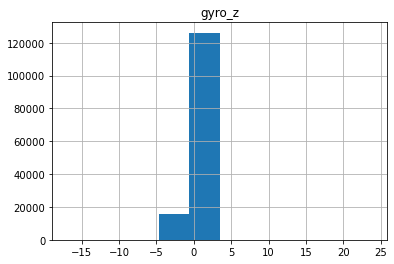

In [95]:
for act in ['Lying (Grouped)']:
    base_df[base_df.activity_type==act].hist(column='gyro_z')

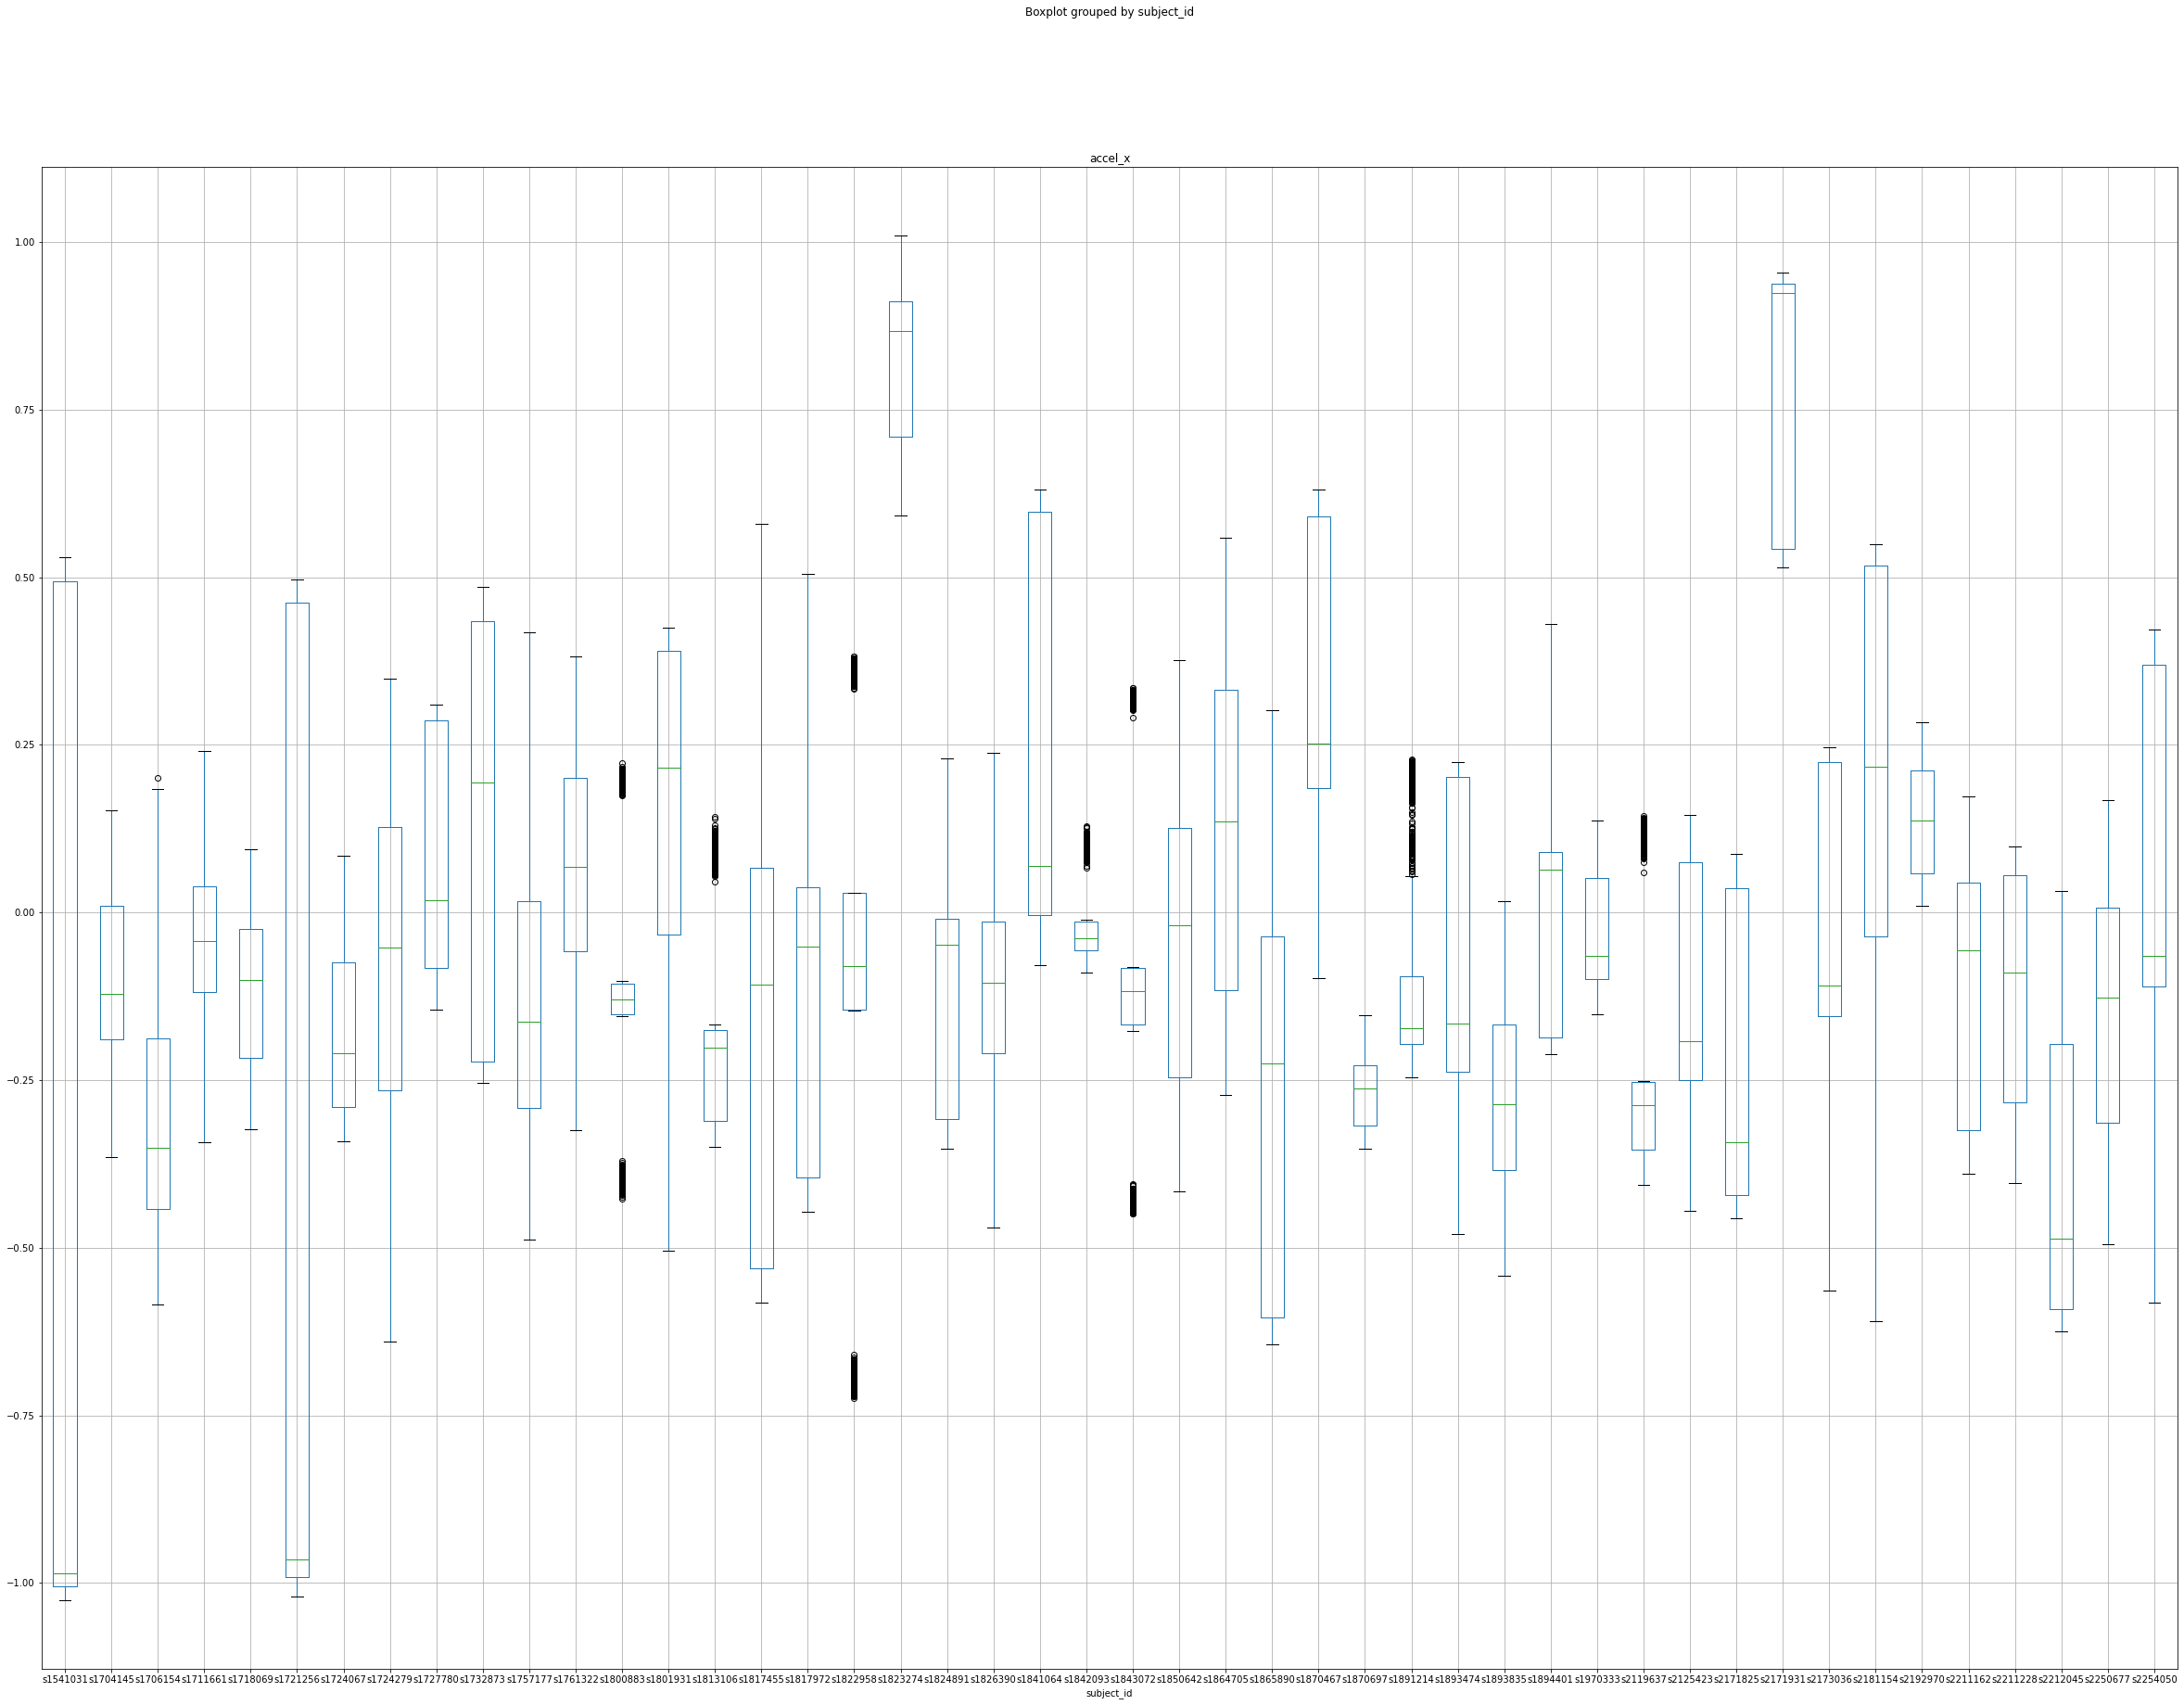

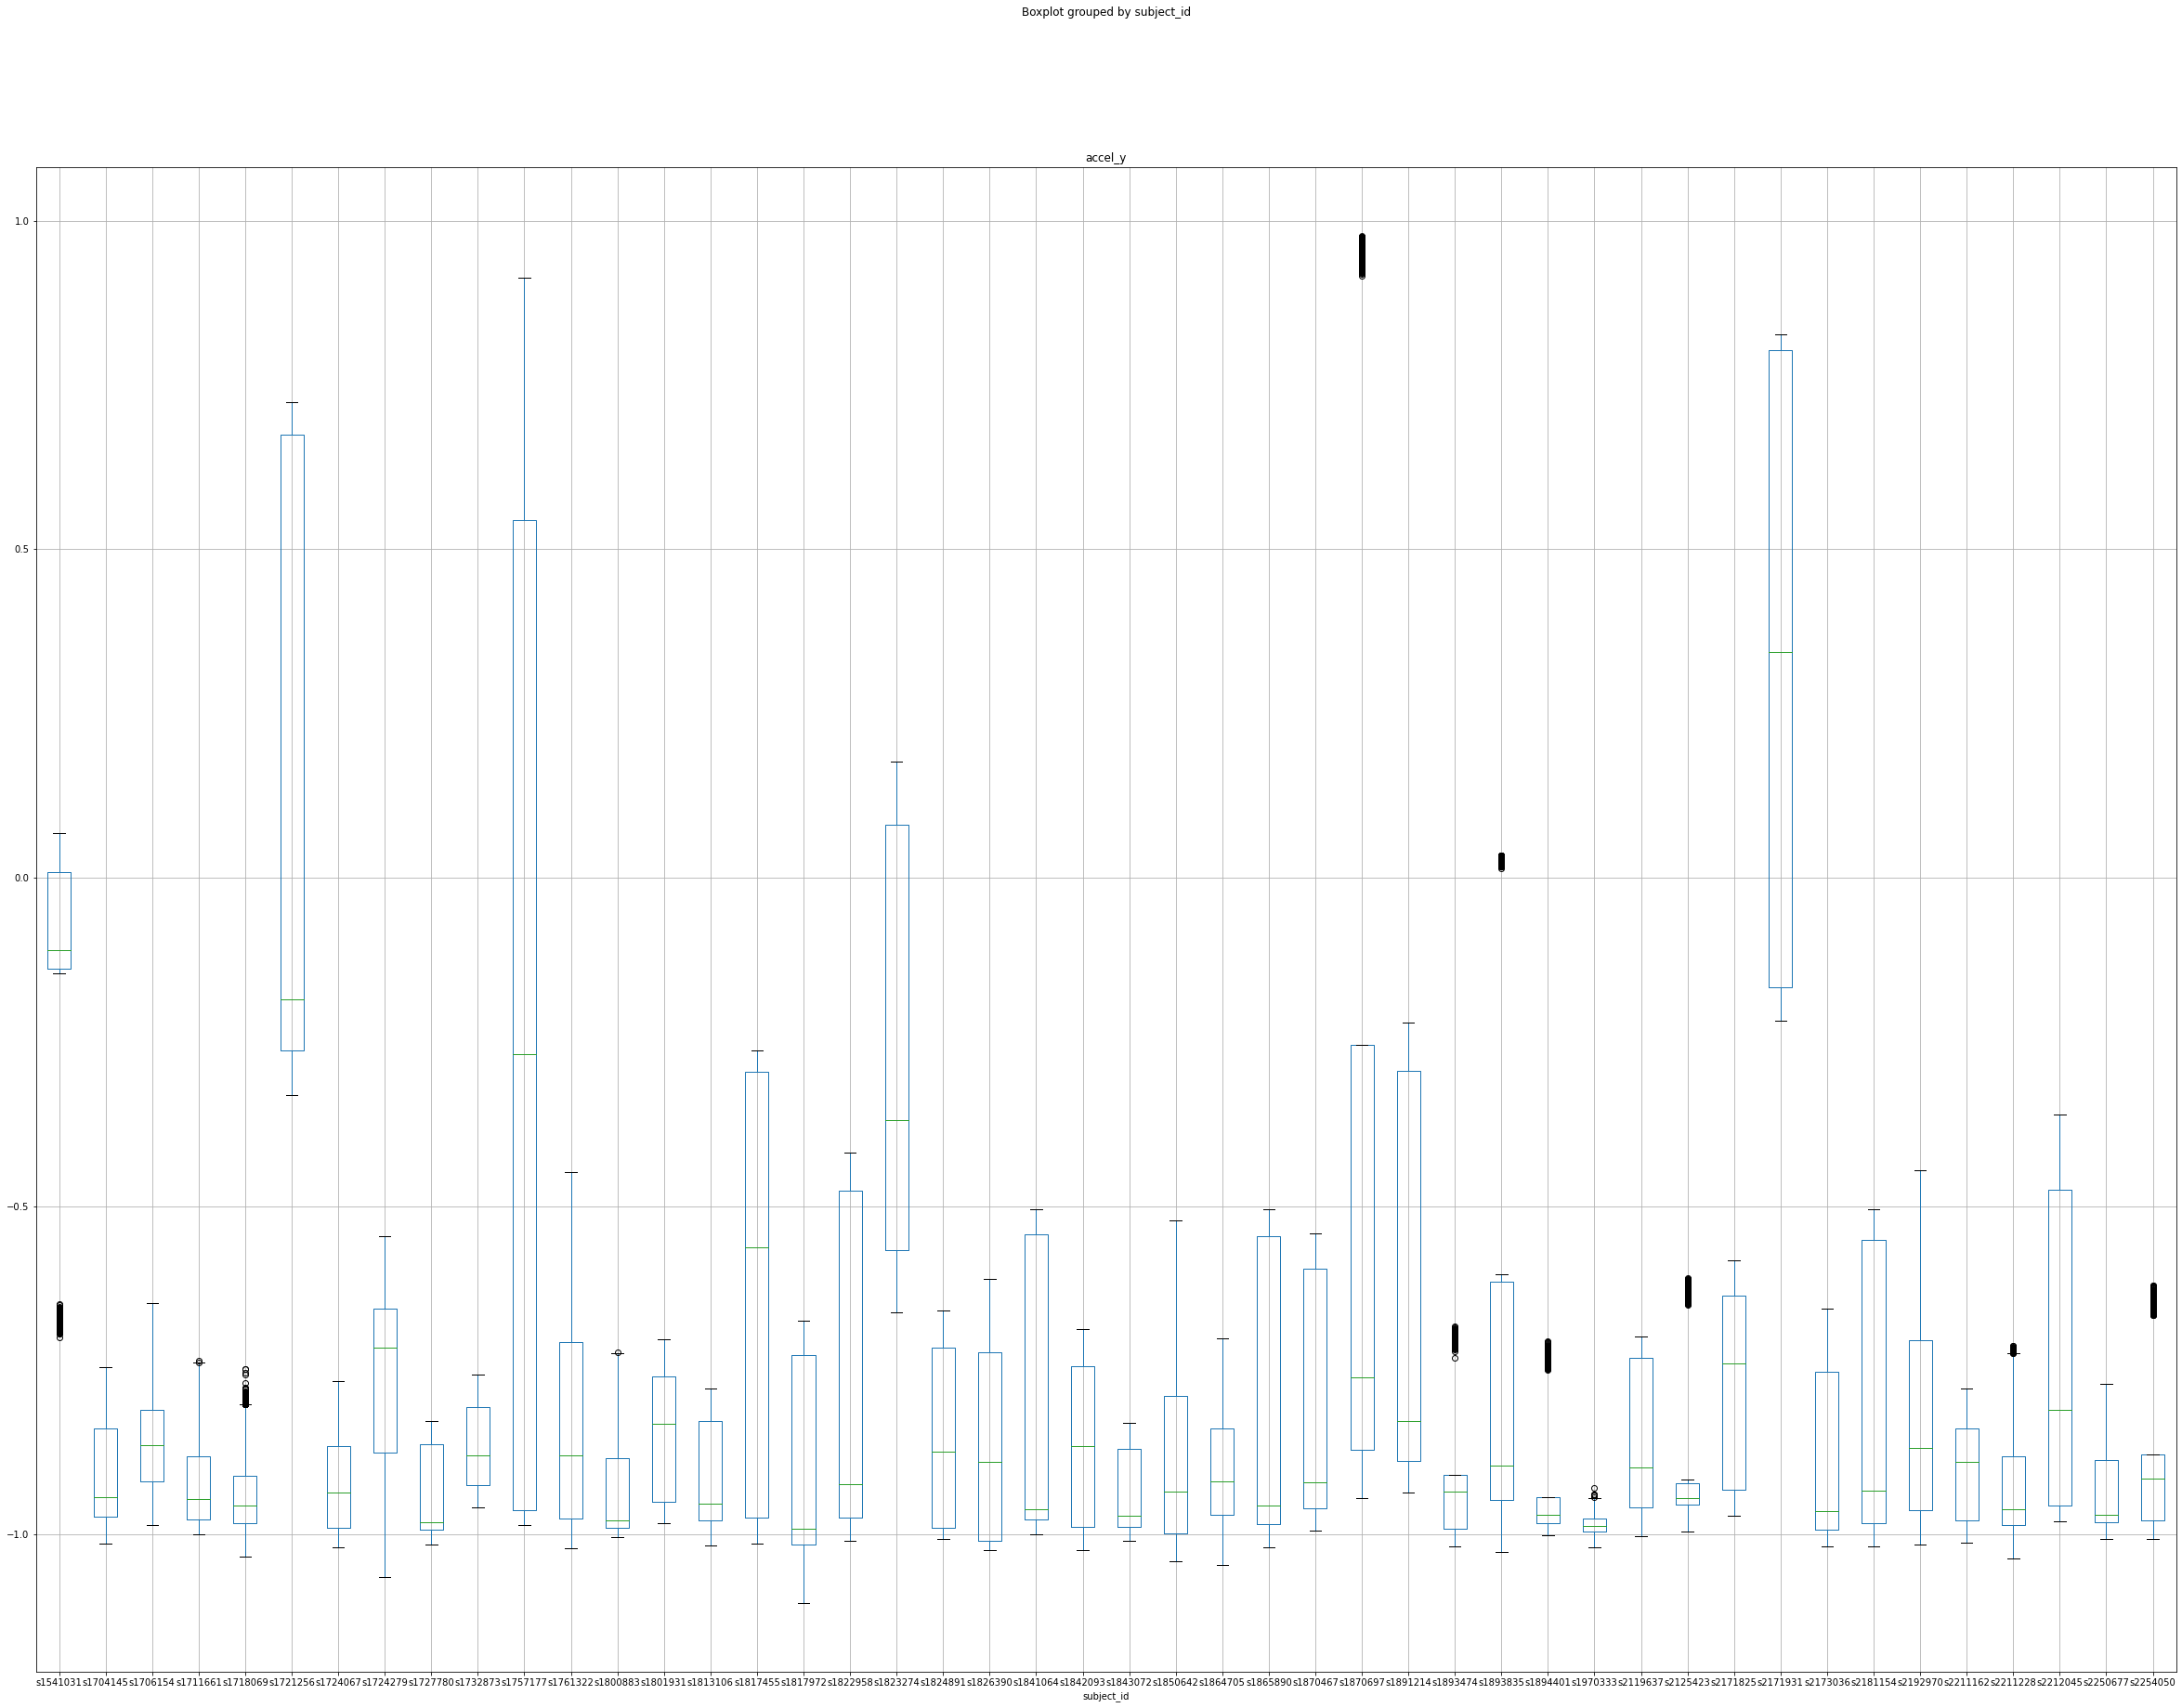

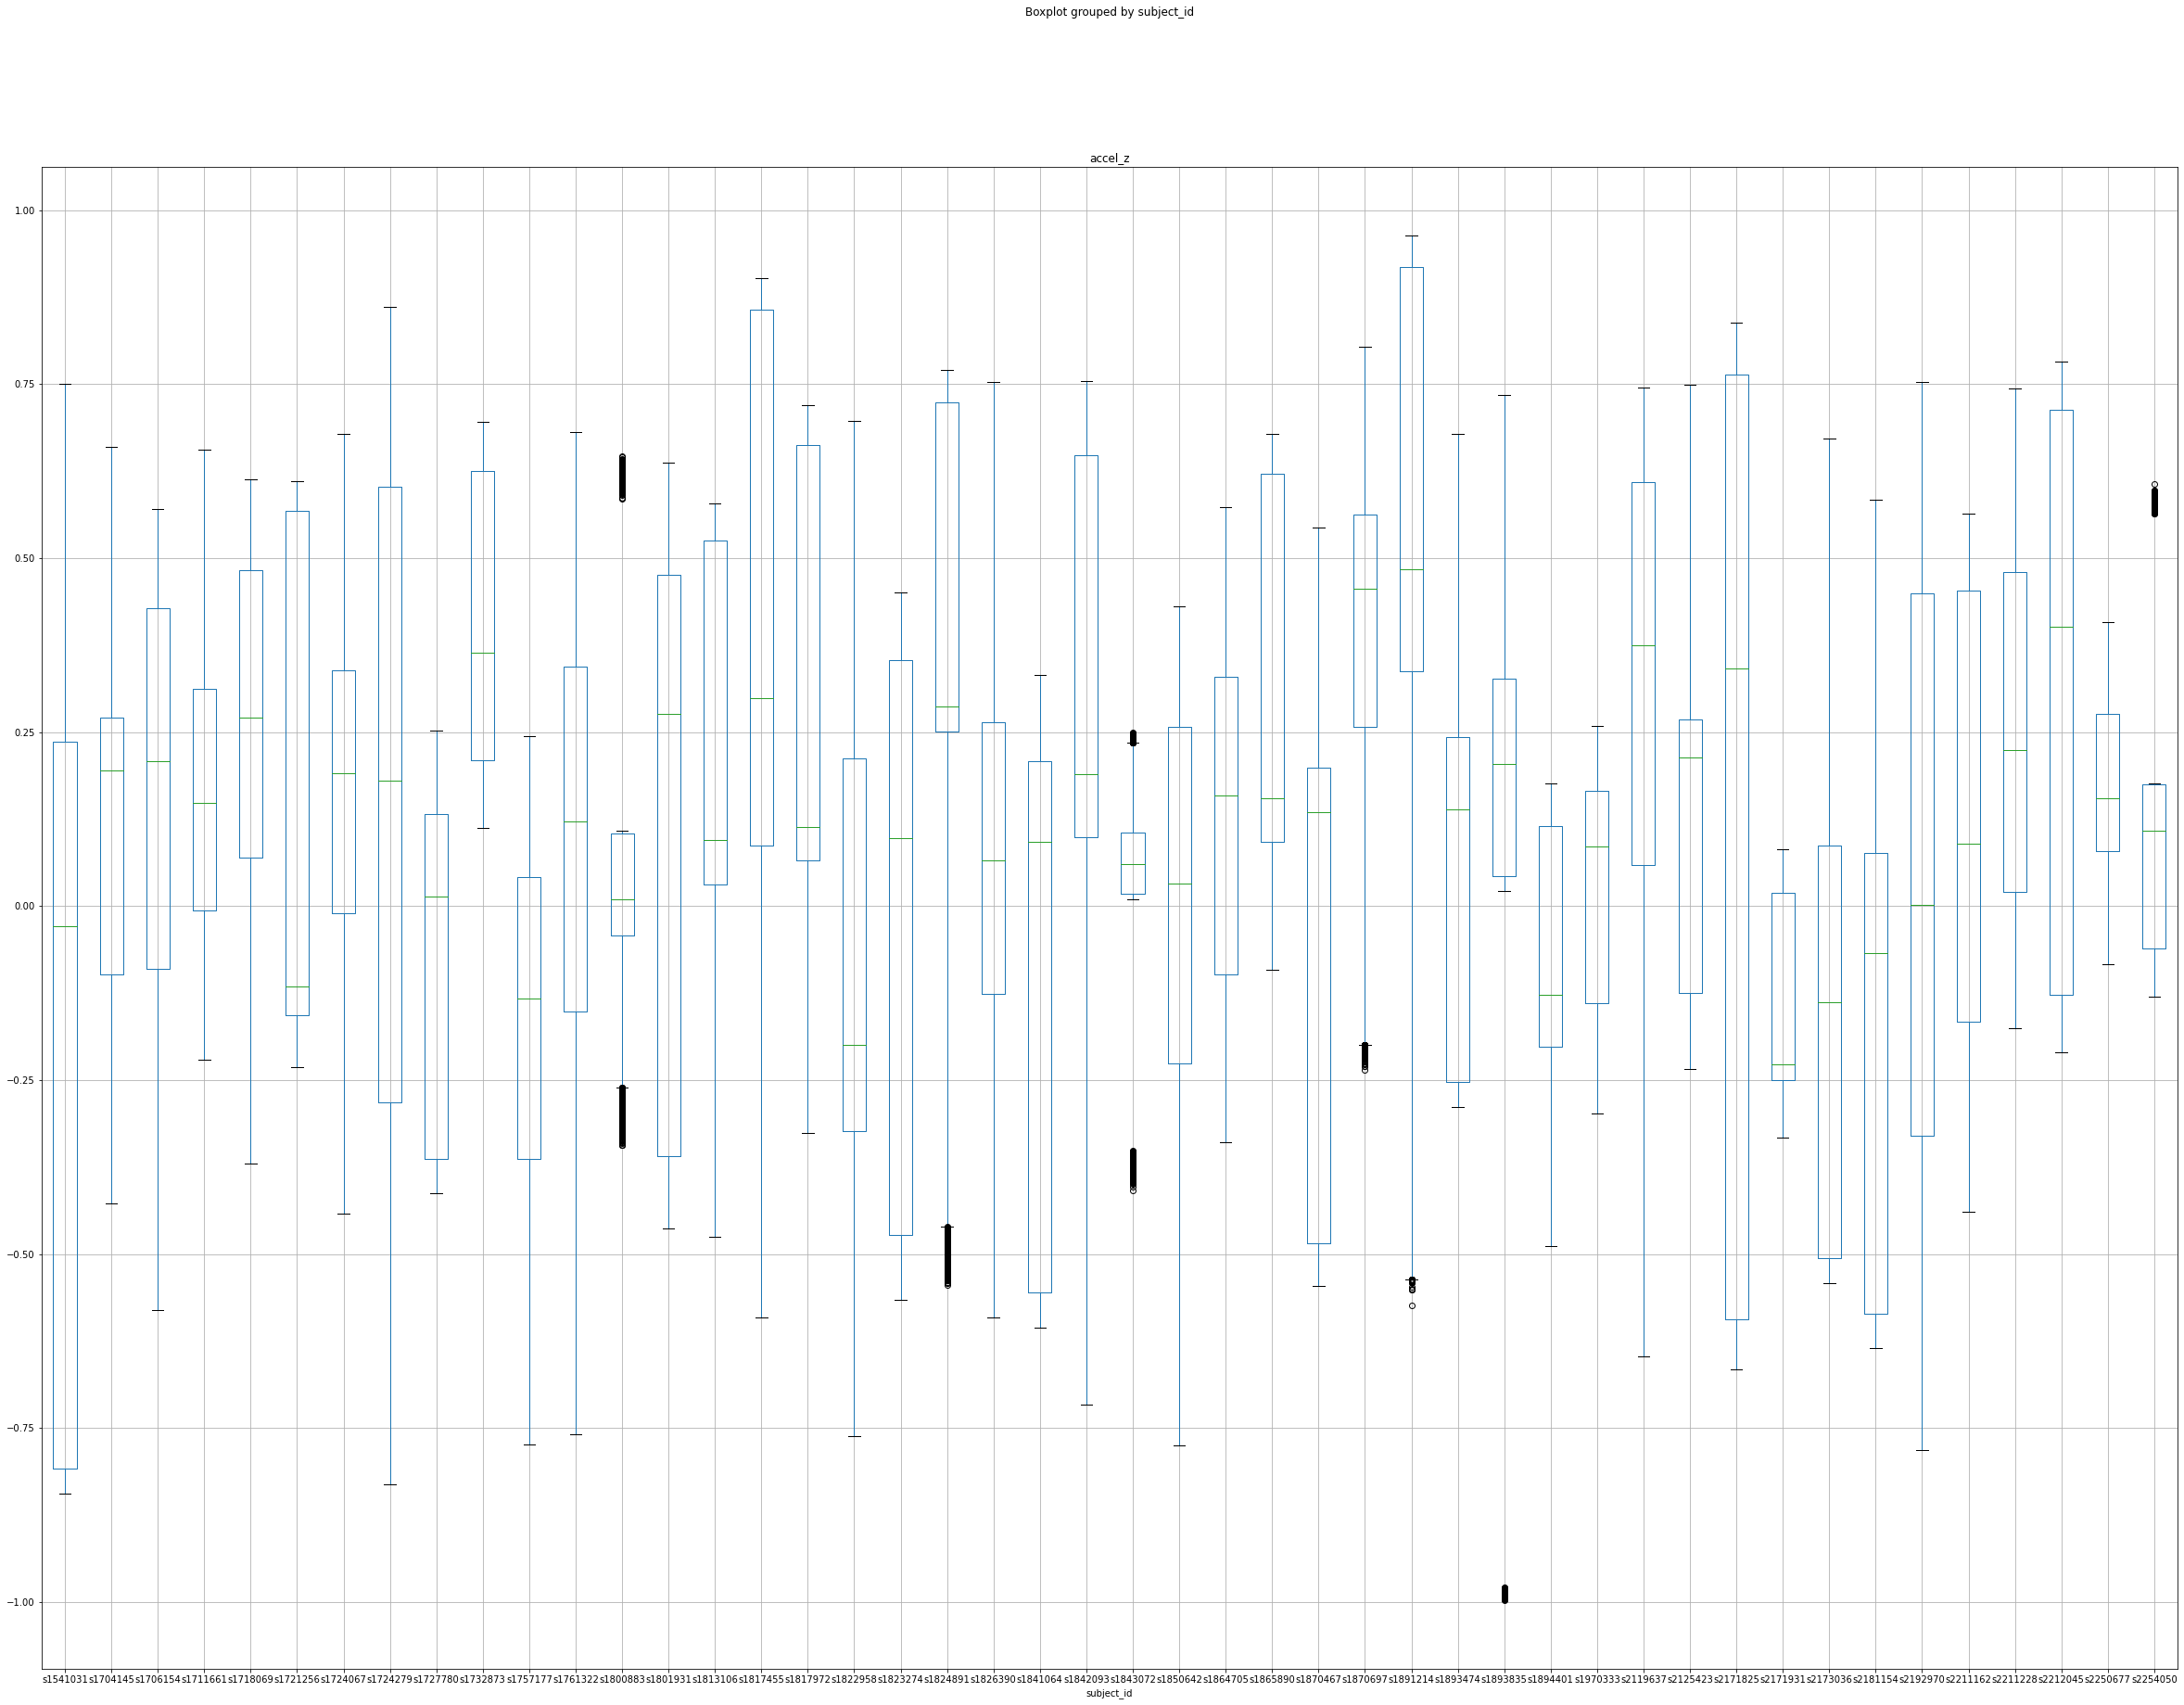

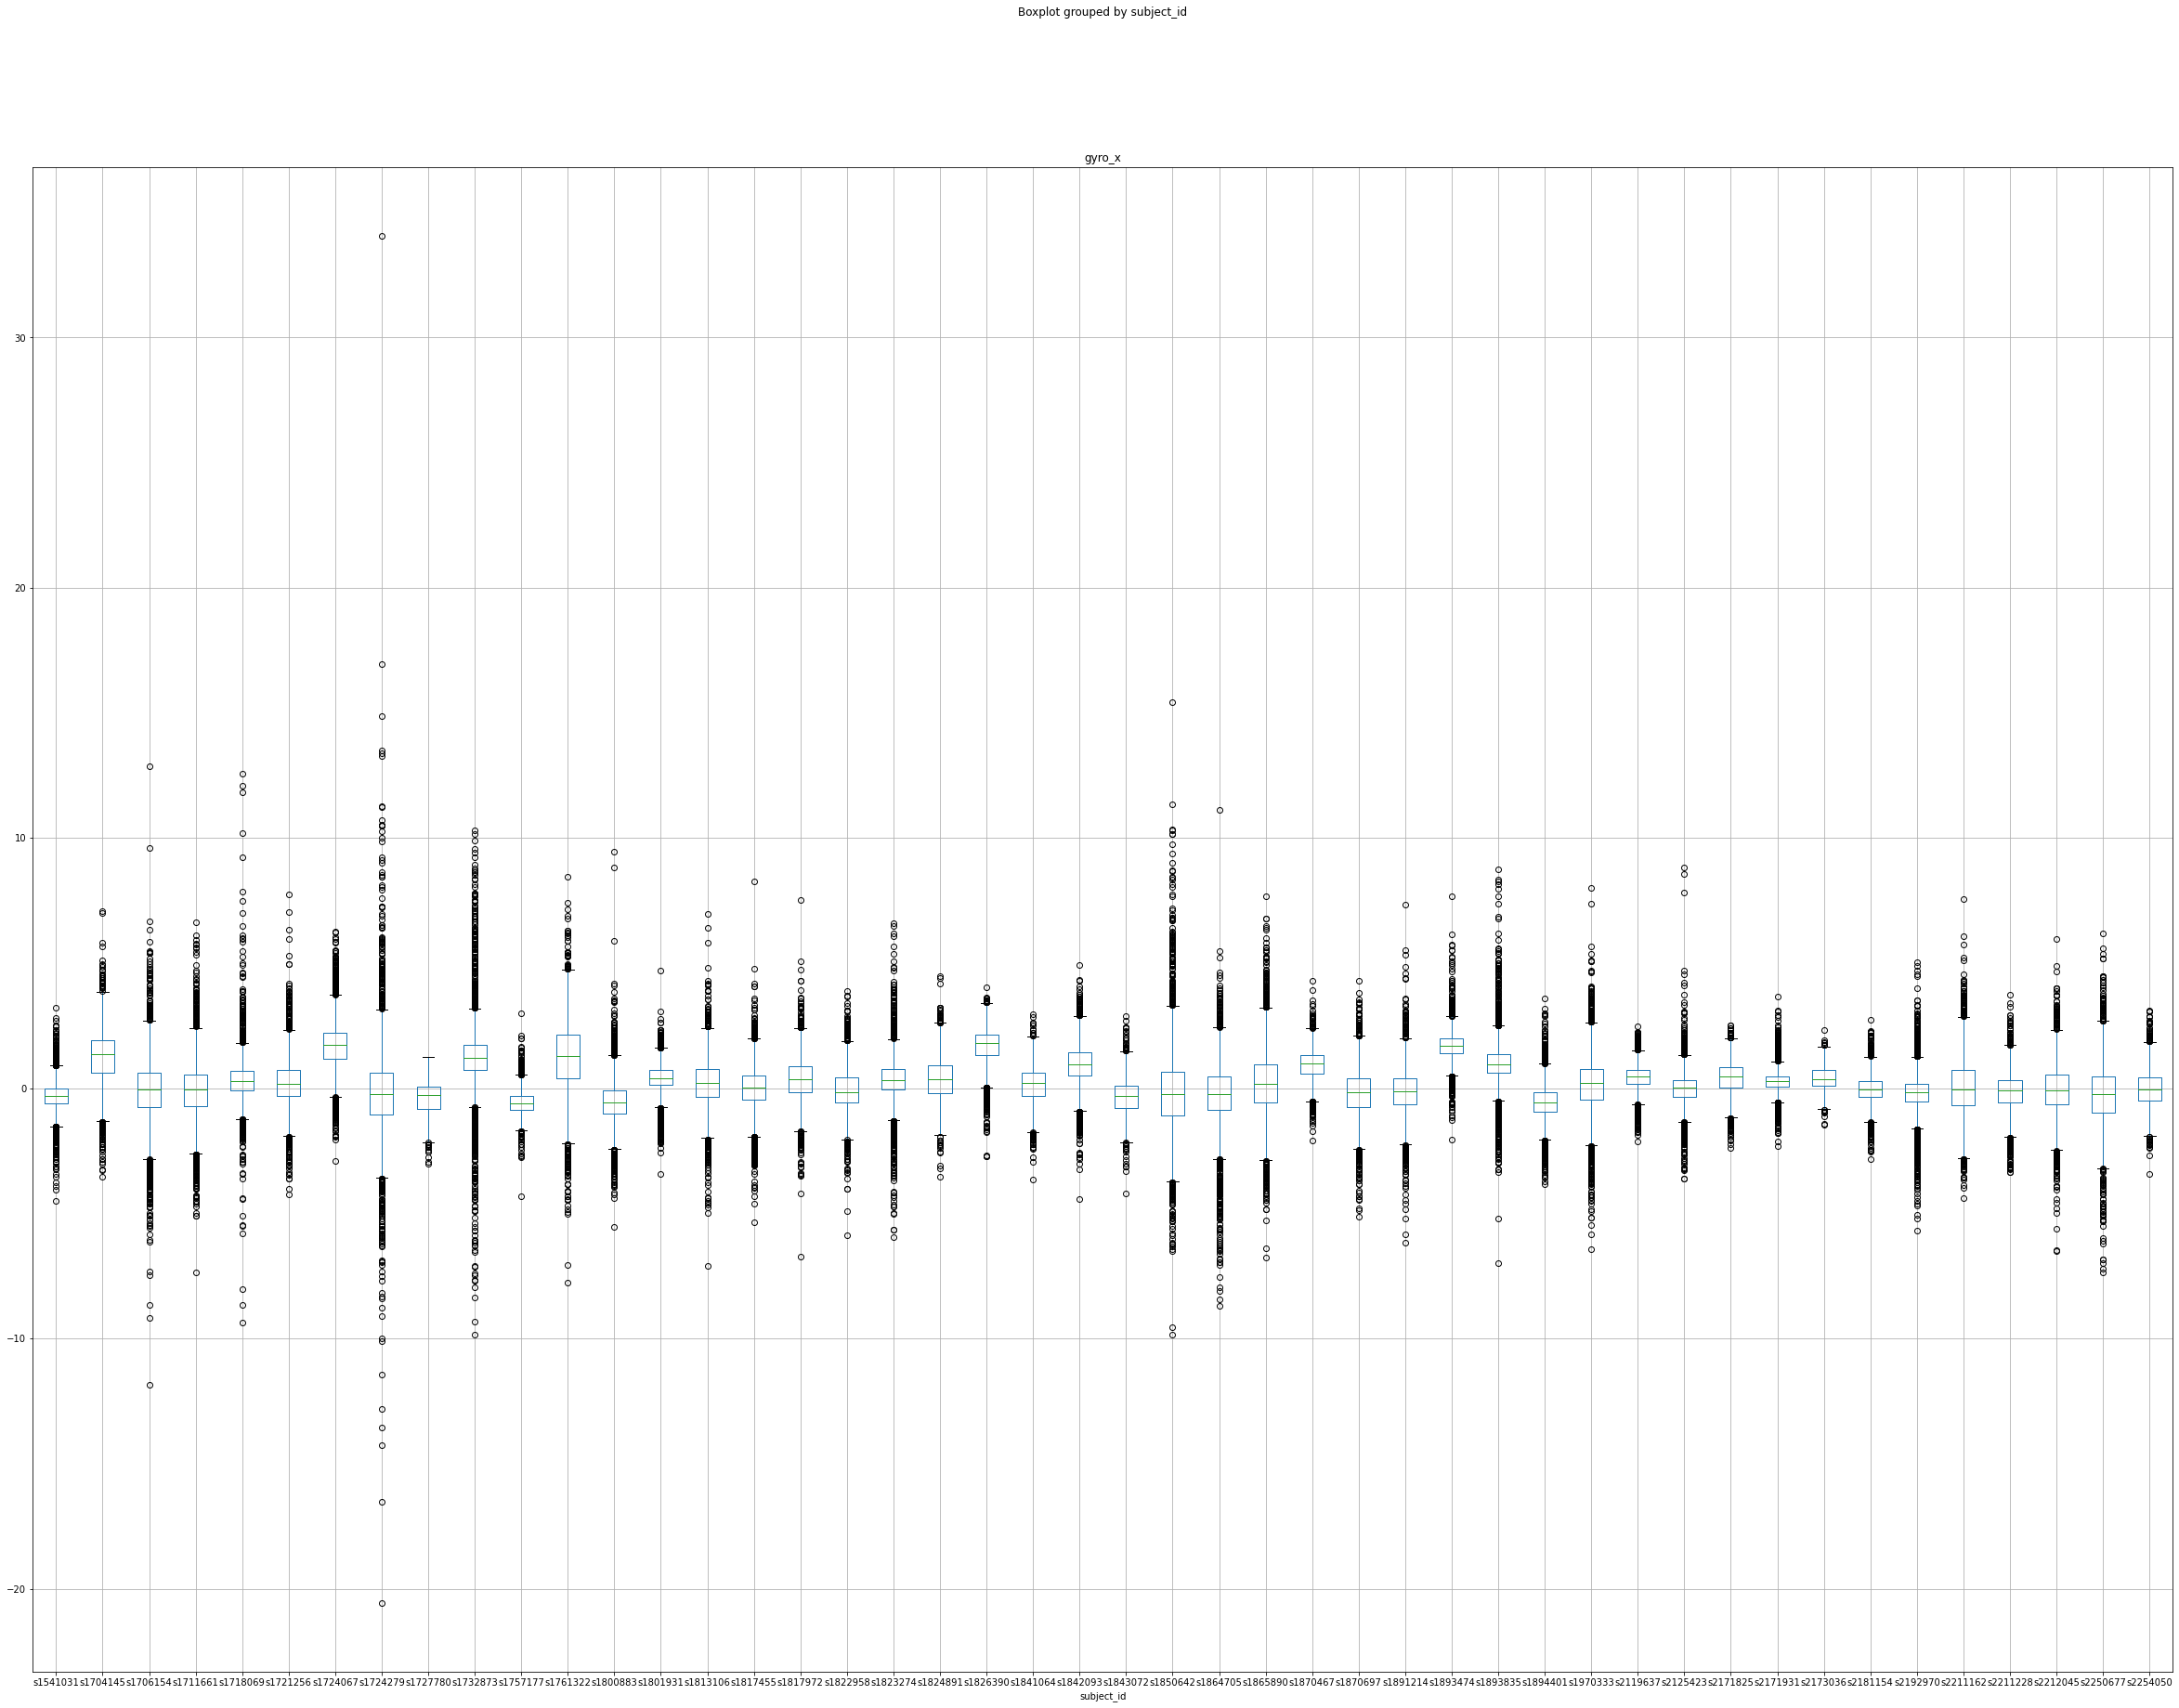

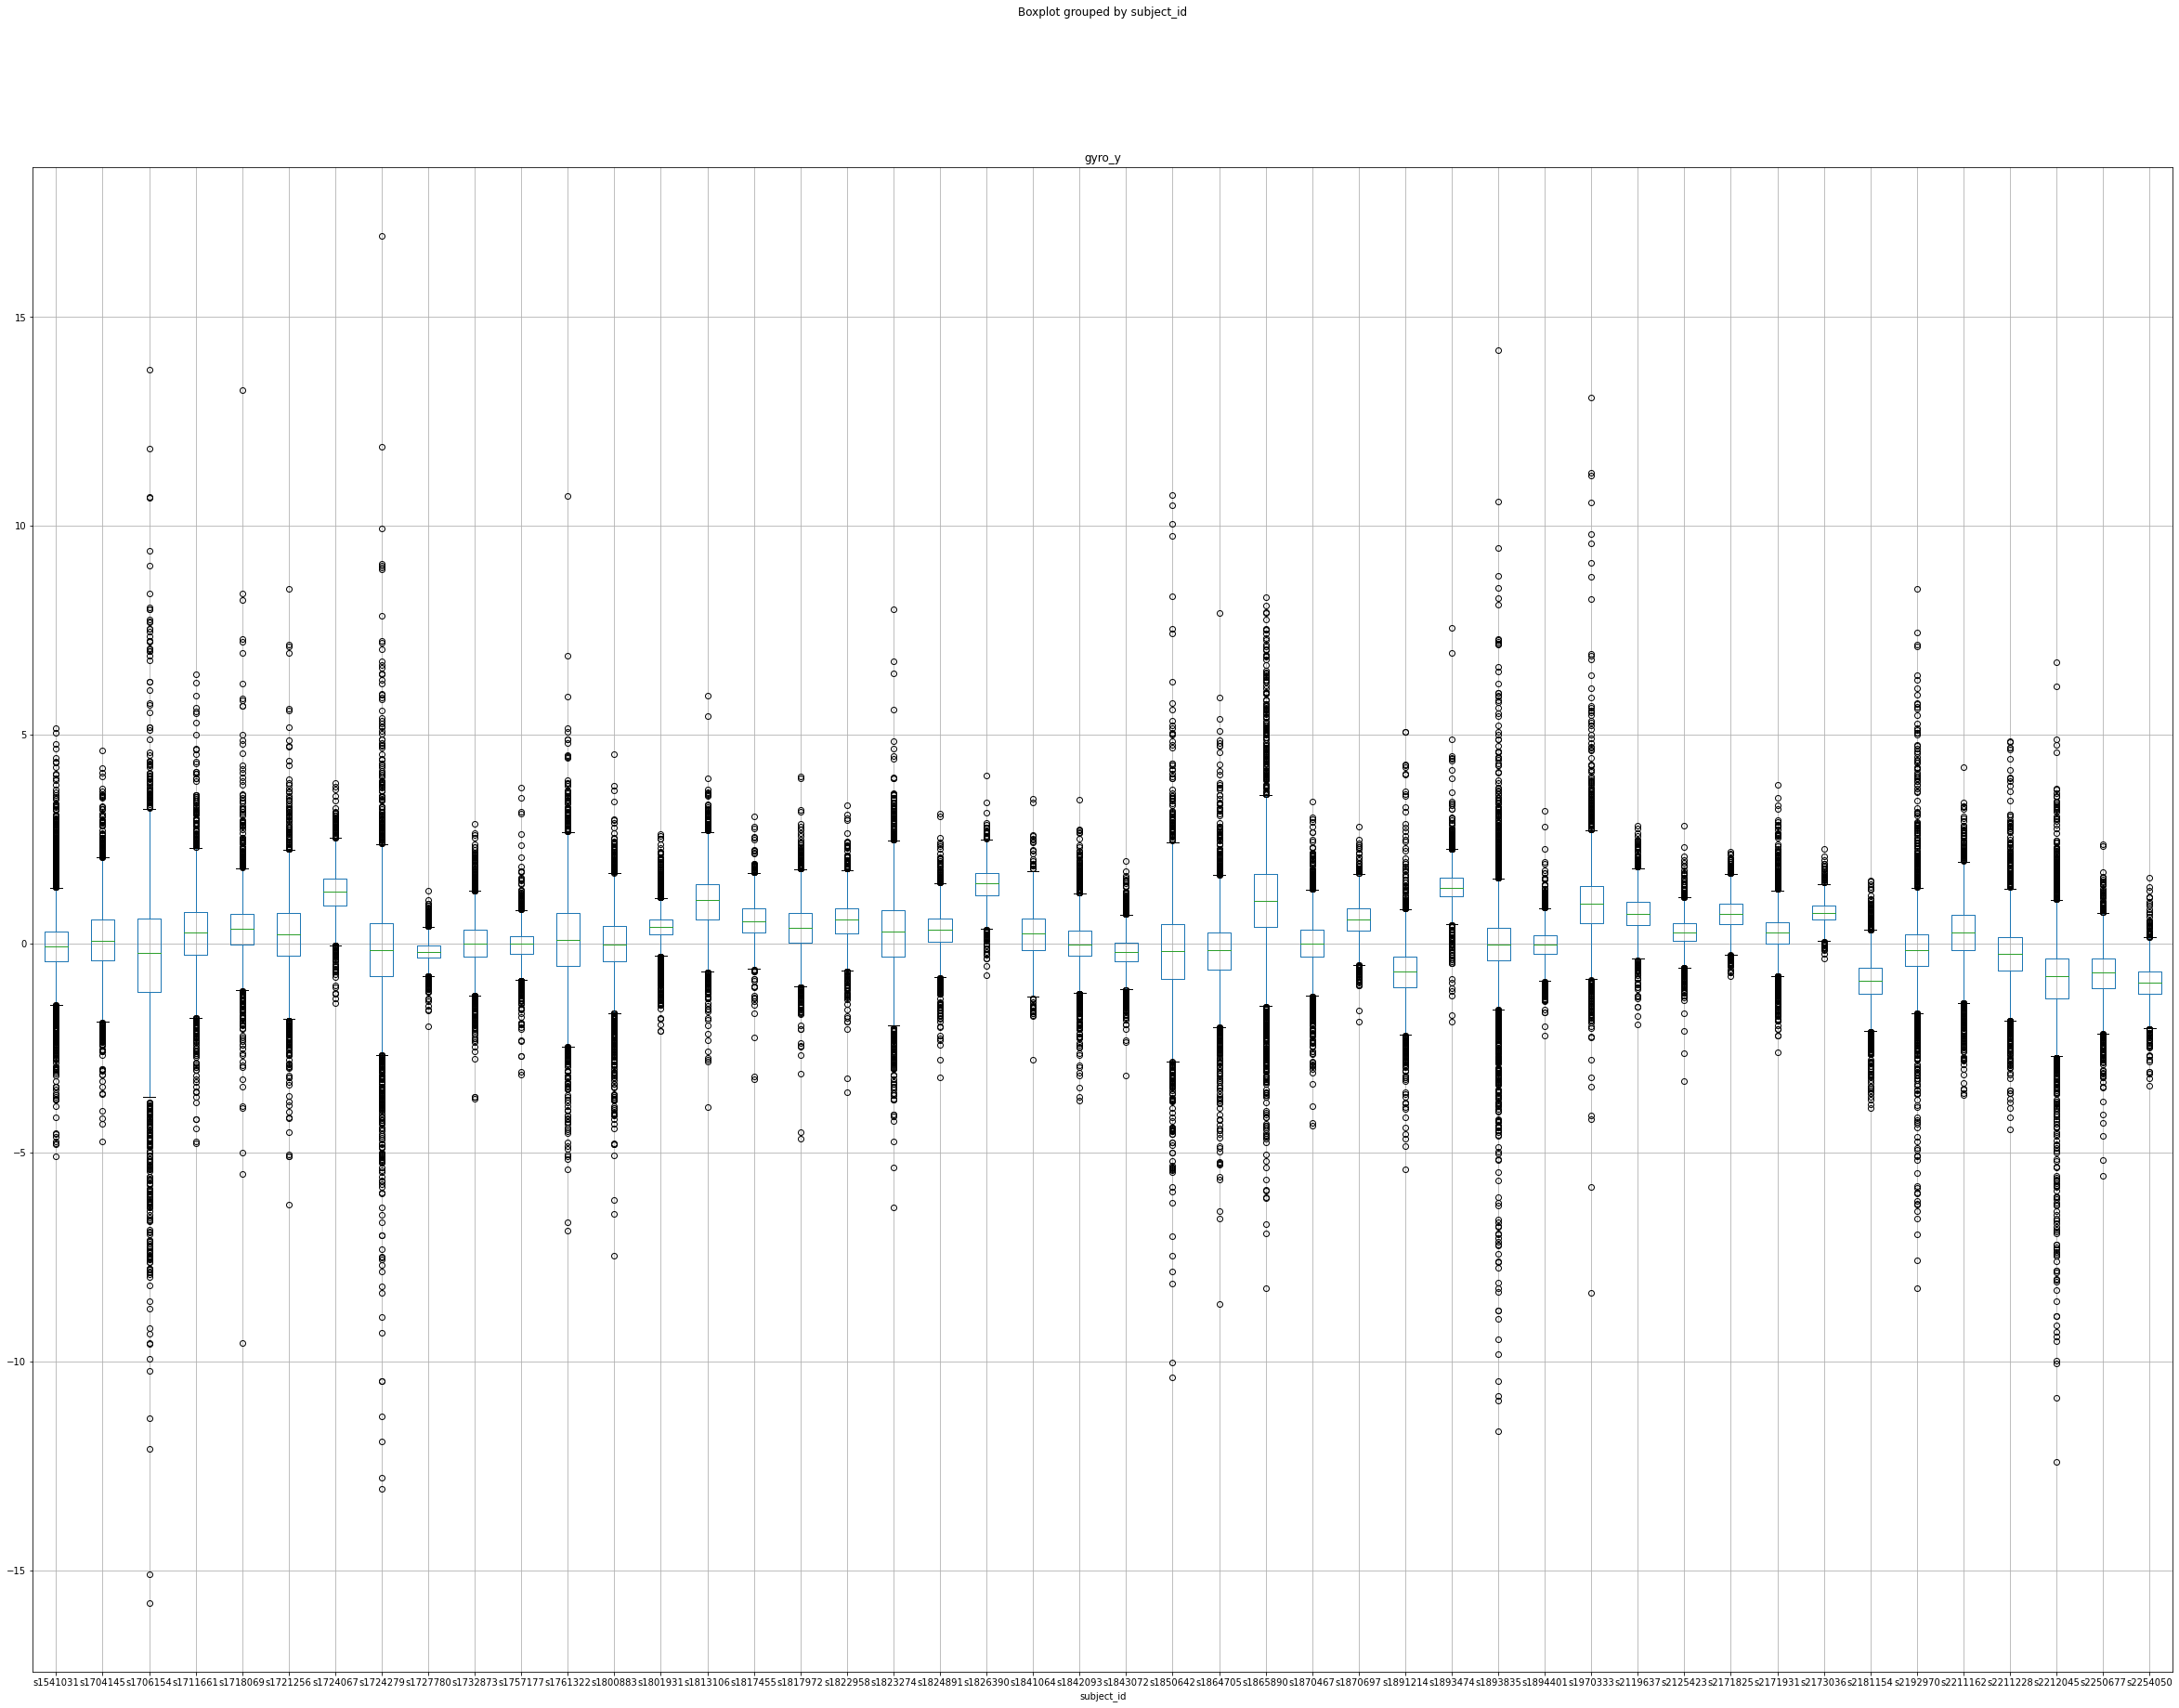

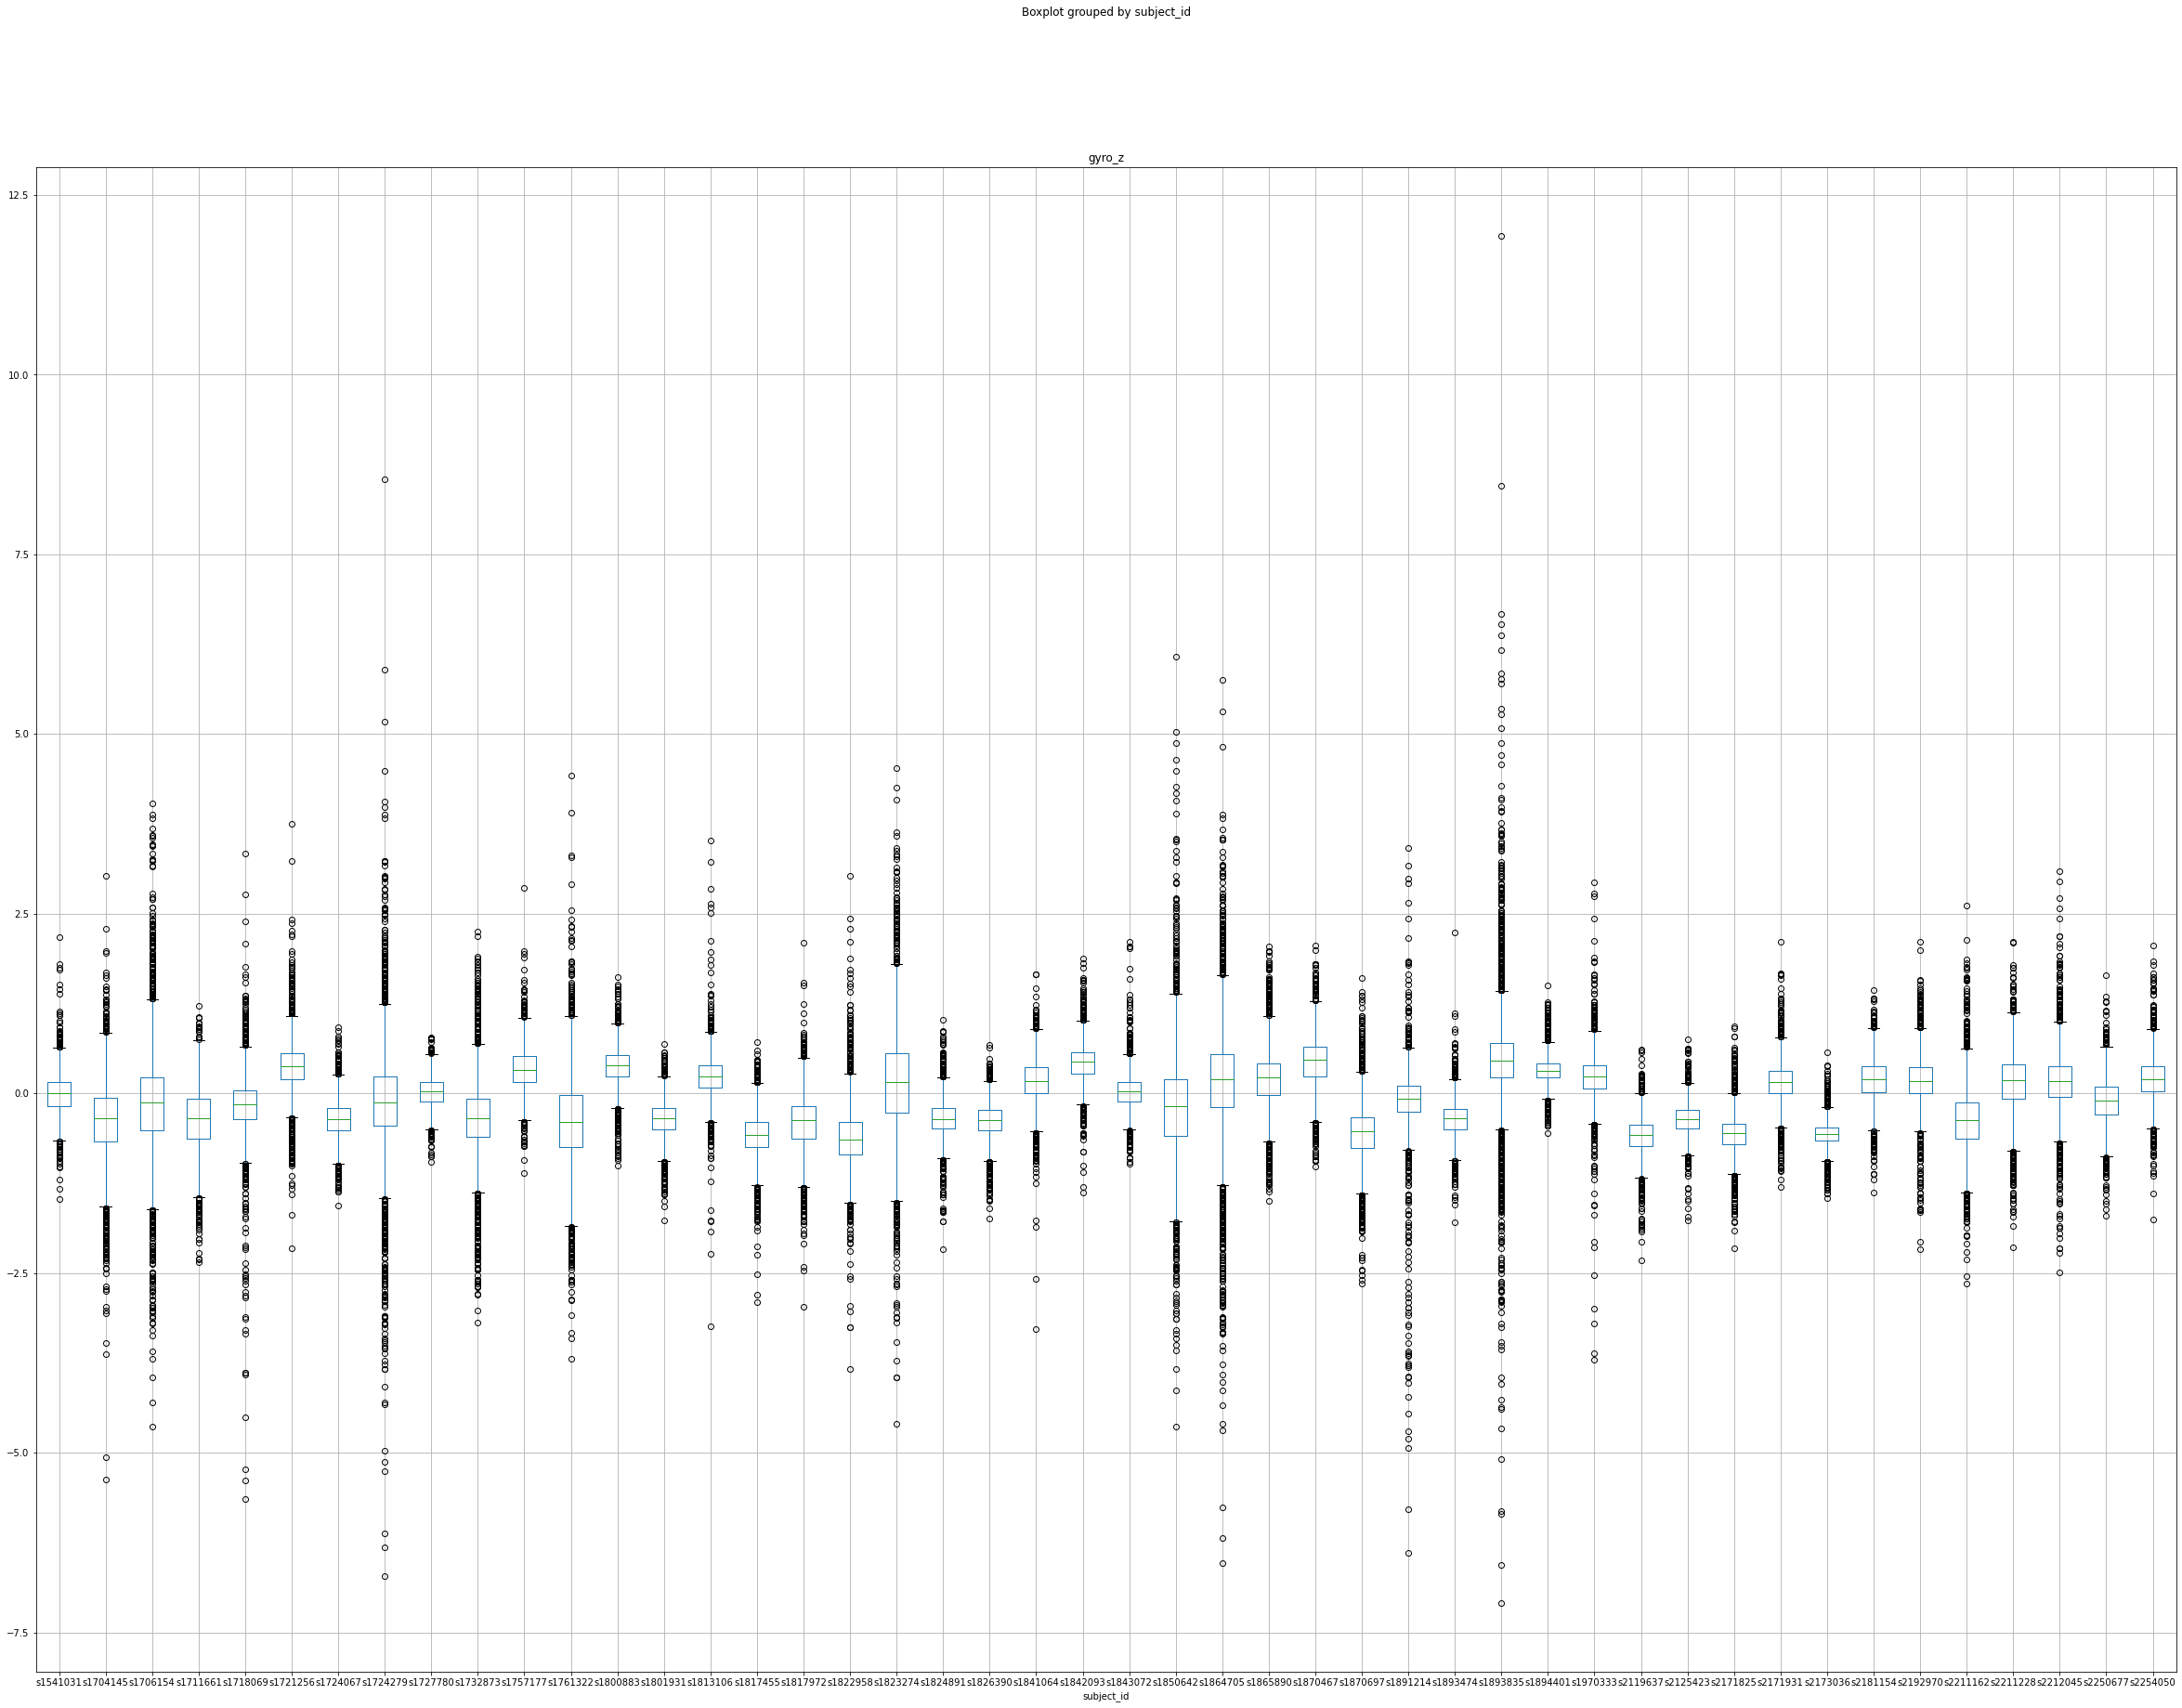

In [101]:
# for subject in all_subject_ids:
#     df= base_df[(base_df.subject_id == subject)]
for act in ['Sitting/Standing']:
    df= base_df[(base_df.activity_type == act)]    
    df.boxplot(column=['accel_x'], by='subject_id', figsize=(40,30))
    df.boxplot(column=['accel_y'], by='subject_id', figsize=(40,30))
    df.boxplot(column=['accel_z'], by='subject_id', figsize=(40,30))
    df.boxplot(column=['gyro_x'], by='subject_id', figsize=(40,30))
    df.boxplot(column=['gyro_y'], by='subject_id', figsize=(40,30))
    df.boxplot(column=['gyro_z'], by='subject_id', figsize=(40,30))


['s1711661' 's1541031' 's1801931']
Processing rid = Climbing stairs
s1711661
['Climbing stairs']
s1541031
['Climbing stairs']
s1801931
['Climbing stairs']


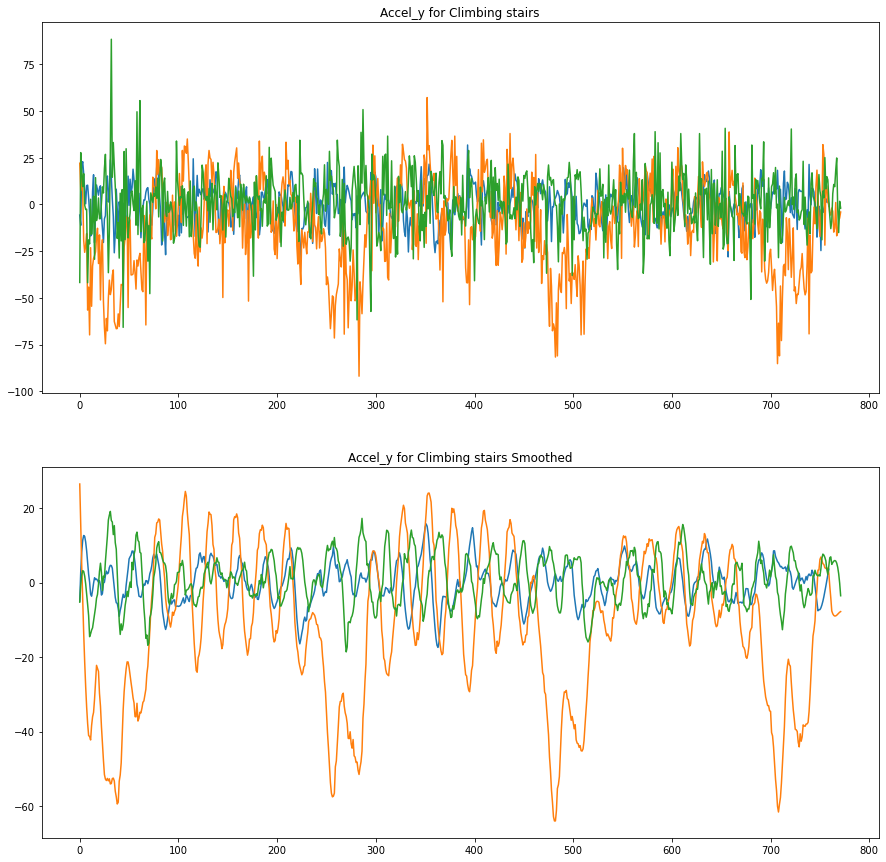

Processing rid = Descending stairs
s1711661
['Descending stairs']
s1541031
['Descending stairs']
s1801931
['Descending stairs']


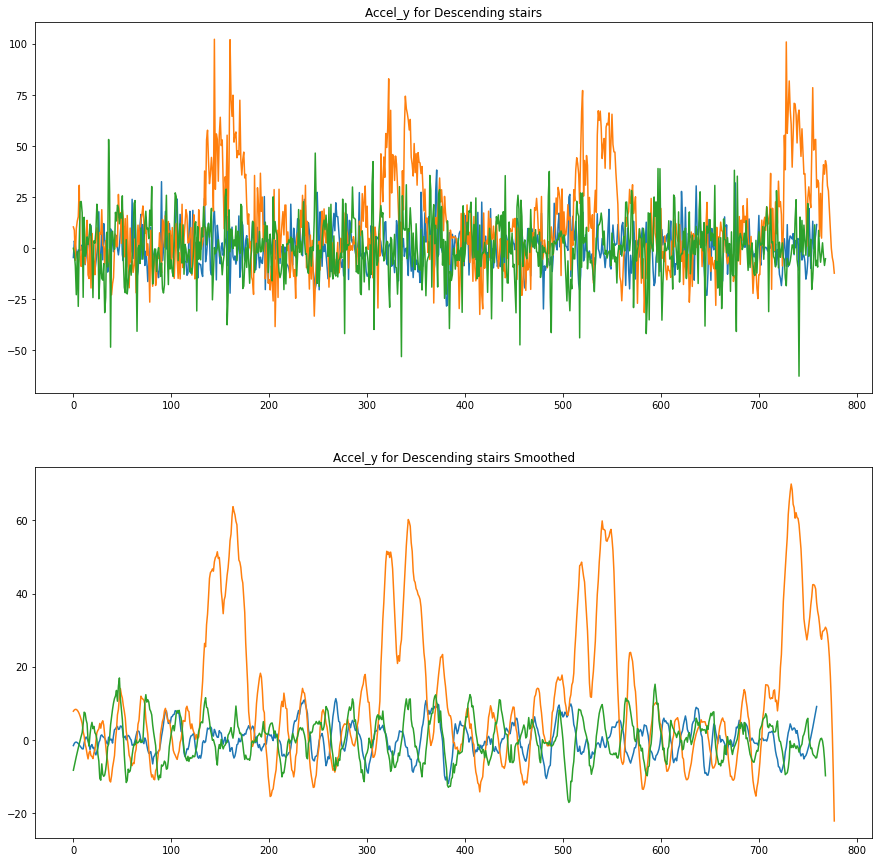

Processing rid = Desk work
s1711661
['Desk work']
s1541031
['Desk work']
s1801931
['Desk work']


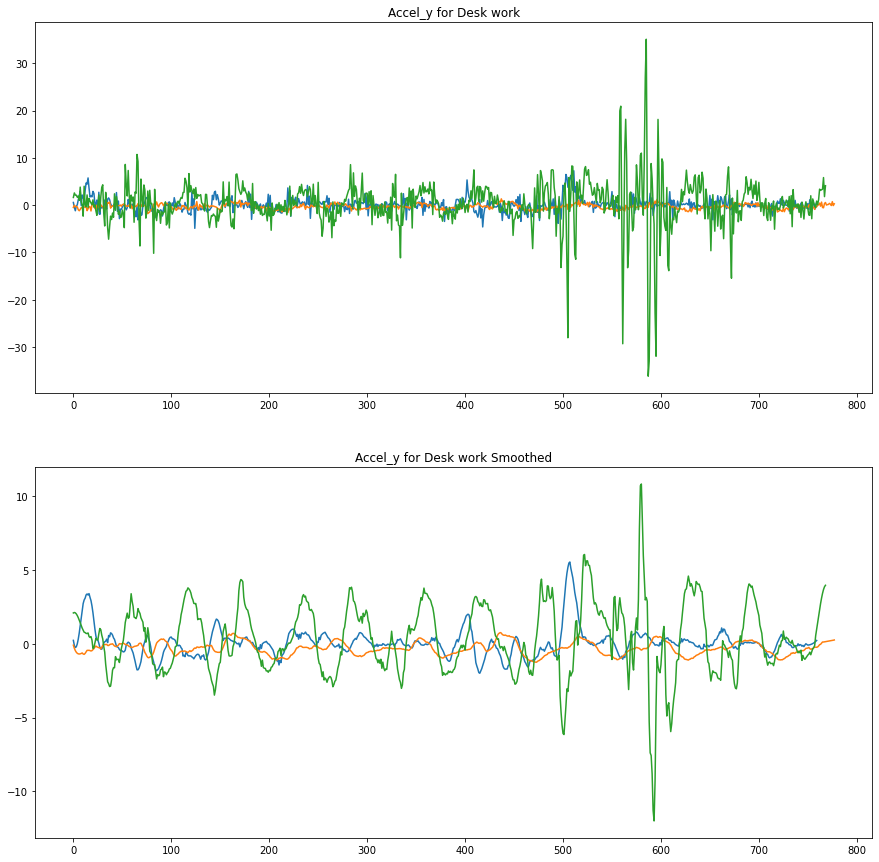

Processing rid = Lying (Grouped)
s1711661
['Lying (Grouped)']
s1541031
['Lying (Grouped)']
s1801931
['Lying (Grouped)']


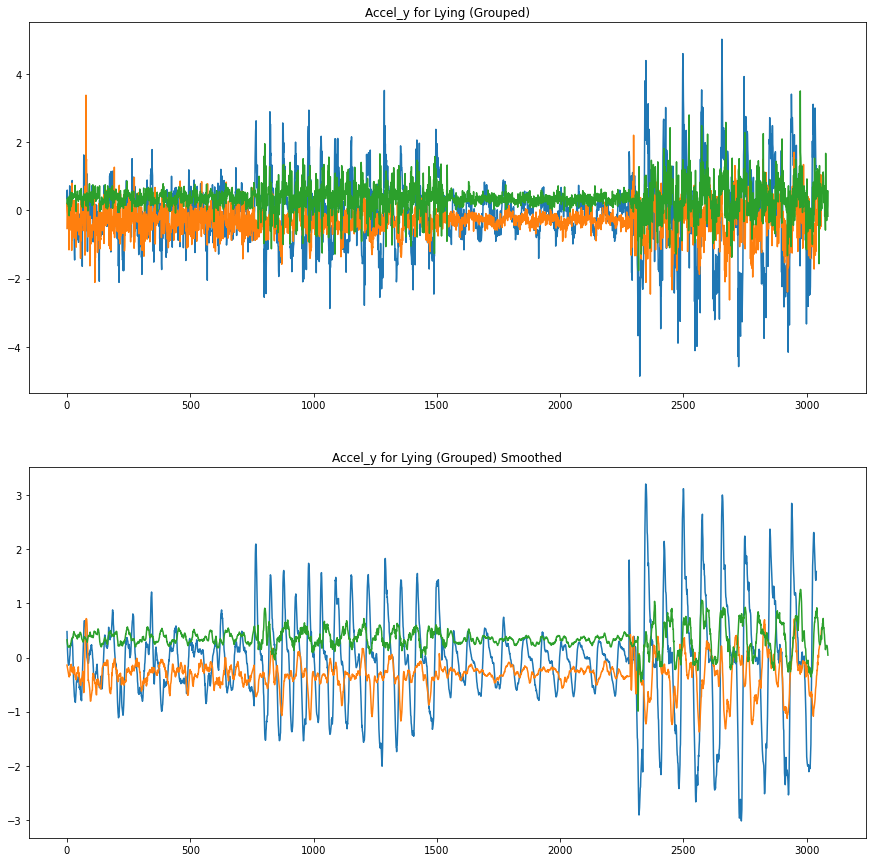

Processing rid = Movement
s1711661
['Movement']
s1541031
['Movement']
s1801931
['Movement']


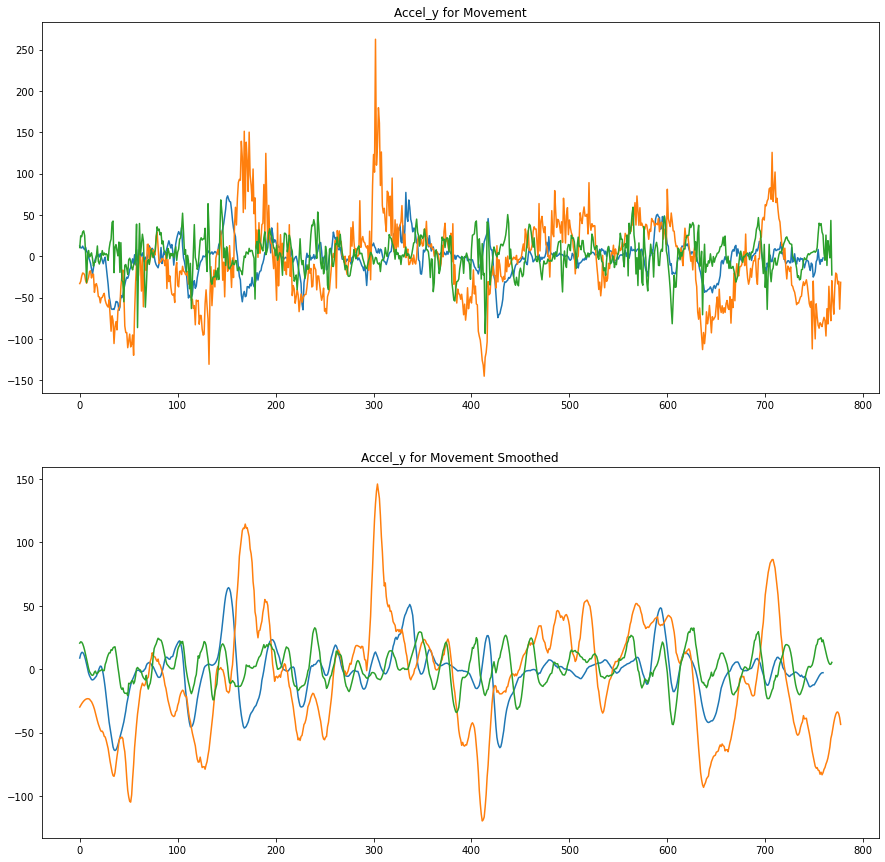

Processing rid = Running
s1711661
['Running']
s1541031
['Running']
s1801931
['Running']


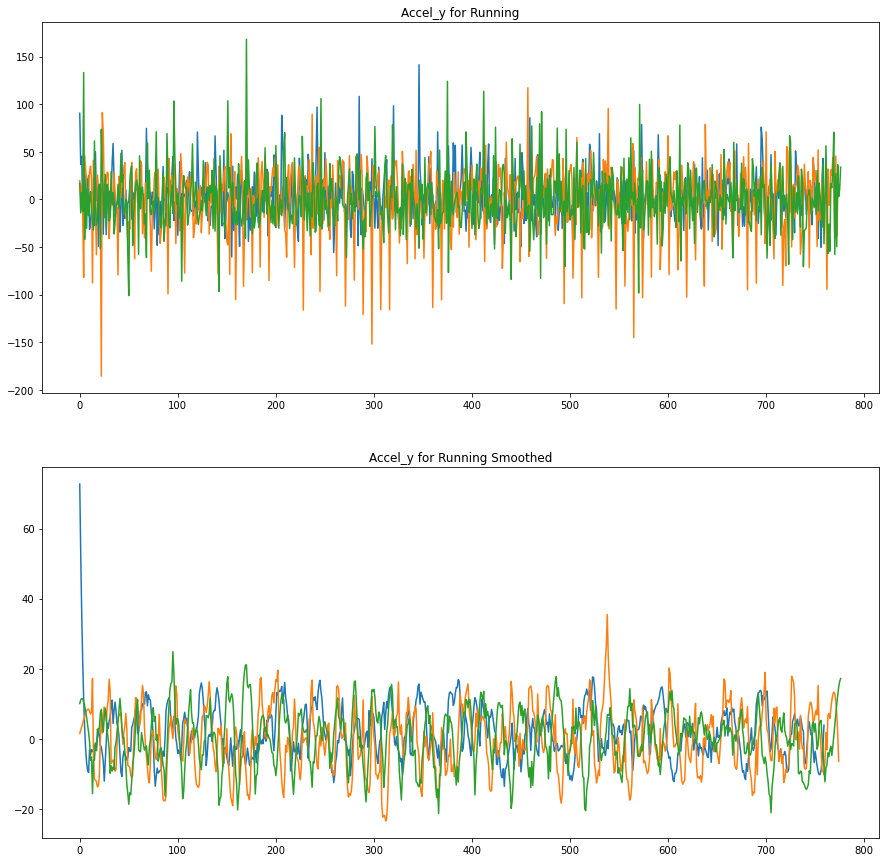

Processing rid = Sitting/Standing
s1711661
['Sitting/Standing']
s1541031
['Sitting/Standing']
s1801931
['Sitting/Standing']


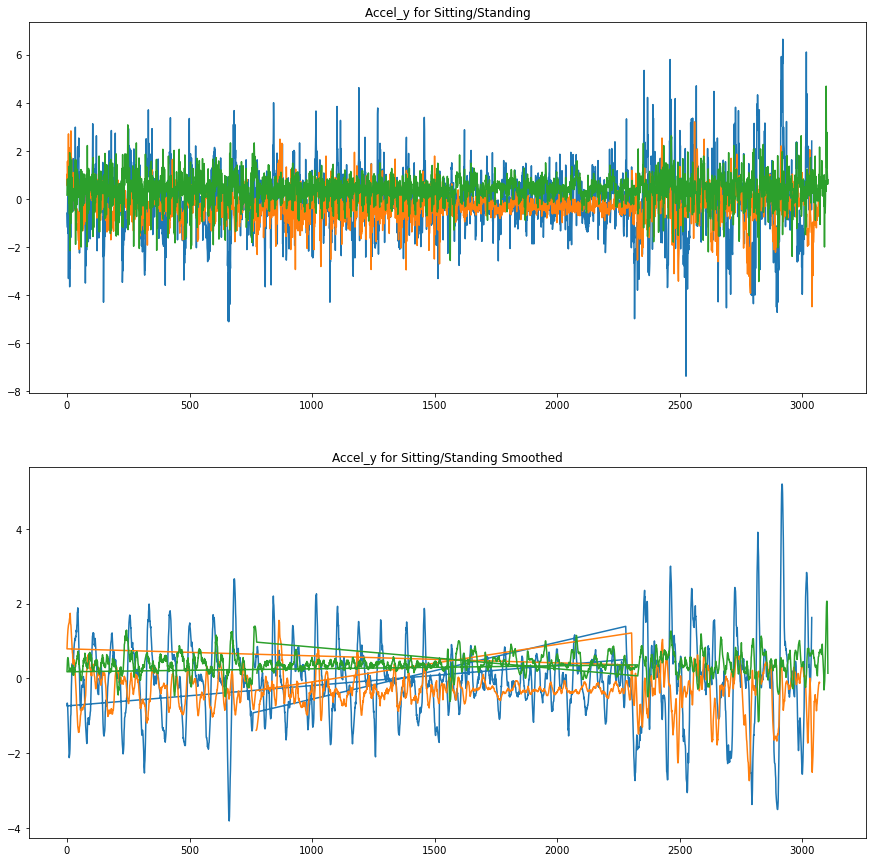

Processing rid = Walking at normal speed
s1711661
['Walking at normal speed']
s1541031
['Walking at normal speed']
s1801931
['Walking at normal speed']


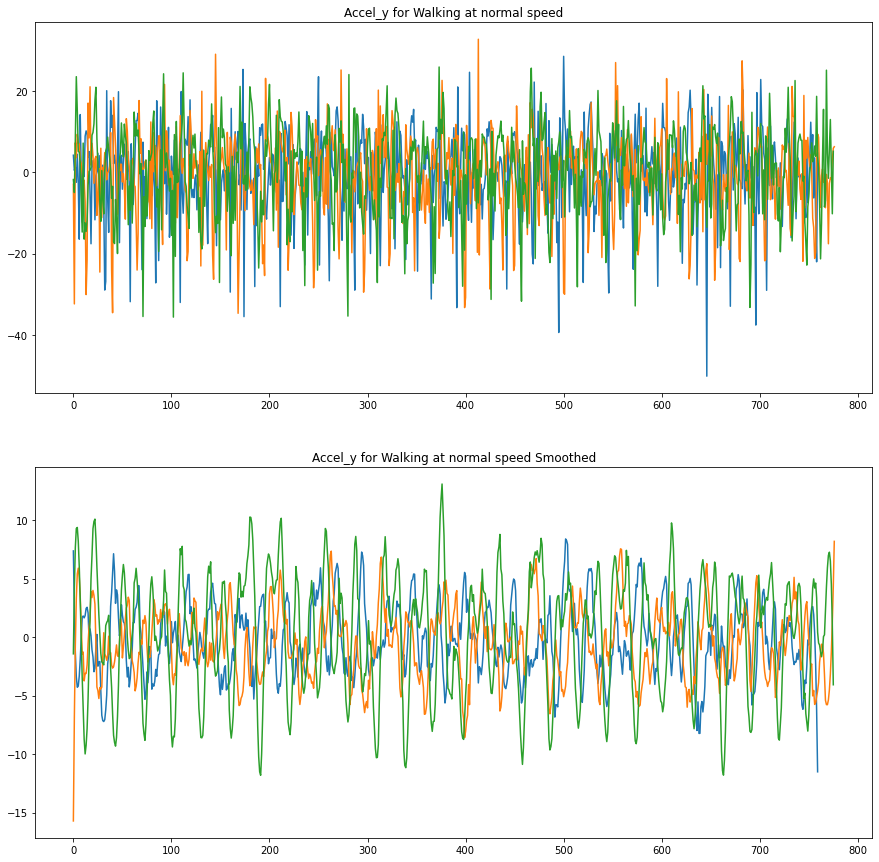

In [33]:
example_df = base_df[base_df['subject_id'].isin(['s1541031', 's1711661','s1801931'])]

subject_ids = example_df['subject_id'].unique()


print(example_df.subject_id.unique())
subject_id_individual_df_dict = {}
for rid, group in example_df.groupby("activity_type"):
    print(f"Processing rid = {rid}")
    
#     group['accel_x']=(group['accel_x']-group['accel_x'].mean())/group['accel_x'].std()

  
    for s_id in subject_ids:
#         current_subject_df = 
        subject_id_individual_df_dict[s_id]= group[group['subject_id'] == s_id].reset_index(drop=True)

    
    
    fig, axs = plt.subplots(2,figsize=(15,15))

    for s_id , df in subject_id_individual_df_dict.items():
        print(s_id)
        print(df['activity_type'].unique())
        axs[0].set_title(f'Accel_y for {rid}')
        axs[0].plot(df['gyro_x'], label=s_id)
        
        df = smooth_signal(df,19,12)
        axs[1].set_title(f'Accel_y for {rid} Smoothed')
        axs[1].plot(df['gyro_x'], label=s_id)
        
    
    ax2.legend()
    ax1.legend()
    plt.show()

    




In [62]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler




[0.30800115]
Mean: -0.443662, StandardDeviation: 0.308001


### TODO:
#### Try normalising 